In [190]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
import operator
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from gensim.corpora.dictionary import Dictionary
from gensim import models
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
wnl = WordNetLemmatizer()

In [191]:
df = pd.read_excel(r'C:\Users\Yunseok Choi\Google 드라이브\기술경영대학원\STEPI\AI_Education_PUB_country.xlsx', index_col = 0)
df.dropna(subset = ['Publication Year','Abstract'], inplace = True)

In [192]:
stword = stopwords.words('english')
#Stopword 추가
stword_add = ['one','two','three','four','five','six','seven','eight','nine','ten', 'increasing','decreasing',
              'half','must','say','said','able','therefore','higher','lower','better','asking','largerst','smallest','come',
             'th','highest','lowest','whatever','help','v','c','high','low','iii','i','ii','iv','v','vi','vii','viii','every',
             'first','second','third','fourth','fifth','sixth','seventh','eighth', 'also', 'table', 'fig']
stword.extend(stword_add)
stword.extend(['de','however','use','used','de'])
stword.extend(['big','small'])

In [193]:
def text_extraction(min_year = 2000,max_year = 2020,country_name = '', data = df):
    i = 0
    cps_name, cps_data = [], []
    if country_name == '':
        for item in df[(df['Publication Year'] <= max_year) & (df['Publication Year'] >= min_year)]['Abstract']:
            globals()['cps{}'.format(i)] = item.lower()
            cps_name.append('cps{}'.format(i))
            cps_data.append(globals()['cps{}'.format(i)])
            i += 1
    if country_name != '':
        for item in df[(df['Publication Year'] <= max_year) & (df['Publication Year'] >= min_year) & (df['Country'] == country_name)]['Abstract']:
            globals()['cps{}'.format(i)] = item.lower()
            cps_name.append('cps{}'.format(i))
            cps_data.append(globals()['cps{}'.format(i)])
            i += 1
    return cps_name, cps_data

In [194]:
#Defining functino for plotting with word frequency limitation as input.
def coherence_score(limit, passes = 15, cps_data = cps_data):
    tokenizer = RegexpTokenizer('\w+')
    p_stemmer = PorterStemmer()
    texts = []
    for item in cps_data:
        #corpus 속 숫자 제거
        temp = re.sub('[0-9]+','',item)
        tokens = tokenizer.tokenize(temp)
        #1글자로 이루어진 단어 제거
        tokens_overone = [word for word in tokens if len(word) > 1]
        #stopword 제거
        stopped_tokens = [i for i in tokens_overone if not i in stword]    
        # ing형 제거
        noning_tokens = [word for word in stopped_tokens if (re.findall('ing$', word) == [])]
        # ly형 제거
        nonly_tokens = [word for word in noning_tokens if (re.findall('ly$', word) == [])]
        #각 단어 표제화
        lemmatized_words = [wnl.lemmatize(i) for i in nonly_tokens]
        texts.append(lemmatized_words)

    frequency = {}
    for corpus in texts:
        for word in corpus:
            if word in frequency.keys():
                frequency[word] +=1
            else:
                frequency[word] = 1
    texts_filtered = [ [token for token in text if (1 < frequency[token] < limit) ] for text in texts ]

    #표제화된 단어들을 이용하여 document-term 테이블 생성
    dictionary = Dictionary(texts_filtered)
    docfreq = dictionary.dfs
    doc_term_matrix = [dictionary.doc2bow(i) for i in texts]

    #토픽의 개수별 gensim LDA 모델의 coherence score 체크
    coherence_values = []
    model_list = []
    for n_topics in range(2,30,1):
        model = models.ldamodel.LdaModel(corpus=doc_term_matrix, num_topics = n_topics, id2word = dictionary, 
                                         passes=passes, alpha = 'symmetric', iterations = 10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())

    x = range(2,30,1)
    plt.plot(x, coherence_values)
    plt.title('Coherence Score of LDA (< {} Counts)'.format(limit))
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.legend(('coherence_values'),loc = 'best')
    return plt.show()

In [195]:
#defining print function of showing 15 keywords and document-topic information, 
#having word frequency limit and number of topics as input.
def lda_analysis(limit, num_tps):
    
    frequency = {}
    for corpus in texts:
        for word in corpus:
            if word in frequency.keys():
                frequency[word] +=1
            else:
                frequency[word] = 1
    texts_filtered = [ [token for token in text if (1 < frequency[token]<limit)] for text in texts ]

    #표제화된 단어들을 이용하여 document-term 테이블 생성
    dictionary = Dictionary(texts_filtered)
    docfreq = dictionary.dfs
    doc_term_matrix = [dictionary.doc2bow(i) for i in texts]

    ldaModel = models.ldamodel.LdaModel(corpus=doc_term_matrix, num_topics = num_tps, id2word = dictionary, 
                                        passes=15, alpha = 'symmetric', iterations = 10)
    ldaTopics = ldaModel.print_topics(num_topics = num_tps, num_words = 15)
    temp = []
    for i in range(len(ldaTopics)):
        string = ''
        for item in ldaTopics[i][1].split('+'):
            string += (item.split('*')[1].replace(r'"','') + '')
        temp.append(['Topic ' + str(ldaTopics[i][0])] + [string.replace(' ',', ')])
    print(temp)
    for i in range(len(doc_term_matrix)):
        print(ldaModel[doc_term_matrix[i]])

## 2010~2020, 전체 데이터

In [206]:
cps_name, cps_data = text_extraction(2010,2020)

In [207]:
#Corpus별 표제어(lemmatization) 추출
tokenizer = RegexpTokenizer('\w+')
p_stemmer = PorterStemmer()
texts = []
for item in cps_data:
    #corpus 속 숫자 제거
    temp = re.sub('[0-9]+','',item)
    tokens = tokenizer.tokenize(temp)
    #1글자로 이루어진 단어 제거
    tokens_overone = [word for word in tokens if len(word) > 1]
    #stopword 제거
    stopped_tokens = [i for i in tokens_overone if not i in stword]    
    # ing형 제거
    noning_tokens = [word for word in stopped_tokens if (re.findall('ing$', word) == [])]
    # ly형 제거
    nonly_tokens = [word for word in noning_tokens if (re.findall('ly$', word) == [])]
    #각 단어 표제화
    lemmatized_words = [wnl.lemmatize(i) for i in nonly_tokens]
    texts.append(lemmatized_words)

frequency = {}
for corpus in texts:
    for word in corpus:
        if word in frequency.keys():
            frequency[word] +=1
        else:
            frequency[word] = 1
texts_filtered = [ [token for token in text if (1 < frequency[token]) ] for text in texts ]

#표제화된 단어들을 이용하여 document-term 테이블 생성
dictionary = Dictionary(texts_filtered)
docfreq = dictionary.dfs
doc_term_matrix = [dictionary.doc2bow(i) for i in texts]

15929


Text(0, 0.5, 'Frequency')

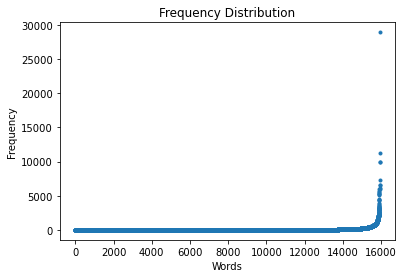

In [40]:
#Cheking the freqeuency distribution with all words.
term_dic = {}
for texts in doc_term_matrix:
    for item in texts:
        if item[0] in term_dic.keys():
            term_dic[item[0]] += item[1]
        else:
            term_dic[item[0]] = 1
term_dic_sorted = sorted(term_dic.items(), key = operator.itemgetter(1))
x , y = [] ,[]
for i in range(len(term_dic_sorted)):
    y.append(term_dic_sorted[i][1])
    x.append(i)
print(len(term_dic_sorted))
plt.plot(x,y, '.')
plt.title('Frequency Distribution')
plt.xlabel('Words')
plt.ylabel('Frequency')

In [200]:
len(cps_data)

9920

In [41]:
for item in sorted(term_dic.items(), key = operator.itemgetter(1), reverse = True)[0:30]:
    print(dictionary[item[0]], item[1])

student 28921
data 11272
study 9980
education 9954
teacher 7315
based 6635
research 6553
approach 6093
result 6030
model 5937
system 5708
university 5558
method 5339
school 5284
paper 5255
course 5163
analysis 4535
process 4393
knowledge 4377
technology 4343
development 3974
deep 3745
educational 3668
new 3553
design 3427
level 3365
information 3362
machine 3249
experience 3209
performance 3153


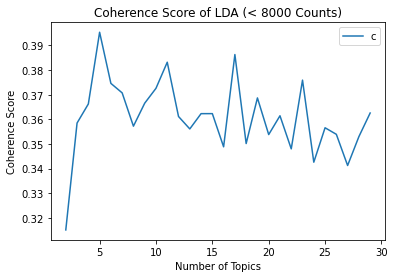

In [208]:
coherence_score(8000, 10)

In [210]:
#Corpus별 표제어(lemmatization) 추출
tokenizer = RegexpTokenizer('\w+')
p_stemmer = PorterStemmer()
texts = []
for item in cps_data:
    #corpus 속 숫자 제거
    temp = re.sub('[0-9]+','',item)
    tokens = tokenizer.tokenize(temp)
    #1글자로 이루어진 단어 제거
    tokens_overone = [word for word in tokens if len(word) > 1]
    #stopword 제거
    stopped_tokens = [i for i in tokens_overone if not i in stword]    
    # ing형 제거
    noning_tokens = [word for word in stopped_tokens if (re.findall('ing$', word) == [])]
    # ly형 제거
    nonly_tokens = [word for word in noning_tokens if (re.findall('ly$', word) == [])]
    #각 단어 표제화
    lemmatized_words = [wnl.lemmatize(i) for i in nonly_tokens]
    #filtered_words = [word for word in lemmatized_words if not word in filter_words]
    texts.append(lemmatized_words)


limit = 8000
num_tps = 5
frequency = {}
for corpus in texts:
    for word in corpus:
        if word in frequency.keys():
            frequency[word] +=1
        else:
            frequency[word] = 1
texts_filtered = [ [token for token in text if (1 < frequency[token]<limit)] for text in texts ]

#표제화된 단어들을 이용하여 document-term 테이블 생성
dictionary = Dictionary(texts_filtered)
docfreq = dictionary.dfs
doc_term_matrix = [dictionary.doc2bow(i) for i in texts]

ldaModel = models.ldamodel.LdaModel(corpus=doc_term_matrix, num_topics = num_tps, id2word = dictionary, 
                                    passes=15, alpha = 'symmetric', iterations = 10)
ldaTopics = ldaModel.print_topics(num_topics = num_tps, num_words = 15)
keywords = []
for i in range(len(ldaTopics)):
    string = ''
    for item in ldaTopics[i][1].split('+'):
        string += (item.split('*')[1].replace(r'"','') + '')
    keywords.append(['Topic ' + str(ldaTopics[i][0])] + [string.replace(' ',', ')])
topic_ratio = []
for i in range(len(doc_term_matrix)):
    topic_ratio.append(ldaModel[doc_term_matrix[i]])

In [213]:
keywords

[['Topic 0',
  'system, course, based, machine, design, paper, tool, online, application, knowledge, technology, process, computer, problem, user'],
 ['Topic 1',
  'model, network, performance, result, method, algorithm, neural, based, proposed, machine, feature, analysis, accuracy, prediction, paper'],
 ['Topic 2',
  'university, technology, development, new, language, information, college, research, educational, paper, english, skill, process, management, knowledge'],
 ['Topic 3',
  'teacher, school, research, experience, practice, approach, social, deeper, knowledge, process, science, finding, context, development, based'],
 ['Topic 4',
  'approach, group, result, year, deep, medical, self, questionnaire, health, level, test, course, method, assessment, academic']]

In [216]:
stword.extend(['year','paper','new'])

In [217]:
df_filtered = df[(df['Publication Year'] <= 2020) & (df['Publication Year'] >= 2010)]
df_filtered.reset_index(inplace = True)

In [218]:
usa_index = df_filtered[df_filtered['Country'] == 'USA'].index

In [219]:
topic_ratio_all = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0}
for index in range(0,df_filtered.shape[0],1):
    for item in topic_ratio[index]:
        topic_ratio_all[item[0]] += item[1]
for index in topic_ratio_all.keys():
    topic_ratio_all[index] = topic_ratio_all[index]/df_filtered.shape[0]
topic_ratio_all

{0: 0.24414562622259836,
 1: 0.15141808007948943,
 2: 0.19742312706376036,
 3: 0.2547533583676165,
 4: 0.14712933164649464,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0}

In [220]:
topic_ratio_usa = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0}
for index in usa_index:
    for item in topic_ratio[index]:
        topic_ratio_usa[item[0]] += item[1]
for index in topic_ratio_usa.keys():
    topic_ratio_usa[index] = topic_ratio_usa[index]/len(usa_index)
topic_ratio_usa

{0: 0.2771550291516912,
 1: 0.11324914308091831,
 2: 0.08950994245242327,
 3: 0.3462945848864657,
 4: 0.16874943916480817,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0}

In [221]:
china_index = df_filtered[df_filtered['Country'] == 'China'].index

In [222]:
topic_ratio_china = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0}
for index in china_index:
    for item in topic_ratio[index]:
        topic_ratio_china[item[0]] += item[1]
for index in topic_ratio_china.keys():
    topic_ratio_china[index] = topic_ratio_china[index]/len(china_index)
topic_ratio_china

{0: 0.2055646137951607,
 1: 0.23616244580734114,
 2: 0.4213083456503534,
 3: 0.07127615433475874,
 4: 0.05830680601524584,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0}

In [223]:
len(china_index)

1518

In [224]:
len(usa_index)

1744

## USA Topic Modeling

In [228]:
i = 0
cps_name, cps_data = [], []
for item in df_filtered[df_filtered['Country'] == 'USA']['Abstract']:
    globals()['cps{}'.format(i)] = item.lower()
    cps_name.append('cps{}'.format(i))
    cps_data.append(globals()['cps{}'.format(i)])
    i += 1

In [226]:
#Corpus별 표제어(lemmatization) 추출
tokenizer = RegexpTokenizer('\w+')
p_stemmer = PorterStemmer()
texts = []
for item in cps_data:
    #corpus 속 숫자 제거
    temp = re.sub('[0-9]+','',item)
    tokens = tokenizer.tokenize(temp)
    #1글자로 이루어진 단어 제거
    tokens_overone = [word for word in tokens if (len(word) > 1)]
    #stopword 제거
    stopped_tokens = [i for i in tokens_overone if not i in stword]    
    # ing형 제거
    noning_tokens = [word for word in stopped_tokens if (re.findall('ing$', word) == [])]
    # ly형 제거
    nonly_tokens = [word for word in noning_tokens if (re.findall('ly$', word) == [])]
    #각 단어 표제화
    lemmatized_words = [wnl.lemmatize(i) for i in nonly_tokens]
    texts.append(lemmatized_words)

frequency = {}
for corpus in texts:
    for word in corpus:
        if word in frequency.keys():
            frequency[word] +=1
        else:
            frequency[word] = 1
texts_filtered = [ [token for token in text if (1 < frequency[token]) ] for text in texts ]

#표제화된 단어들을 이용하여 document-term 테이블 생성
dictionary = Dictionary(texts_filtered)
docfreq = dictionary.dfs
doc_term_matrix = [dictionary.doc2bow(i) for i in texts]

6951


Text(0, 0.5, 'Frequency')

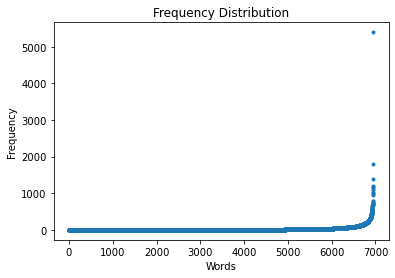

In [63]:
#Cheking the freqeuency distribution with all words.
term_dic = {}
for texts in doc_term_matrix:
    for item in texts:
        if item[0] in term_dic.keys():
            term_dic[item[0]] += item[1]
        else:
            term_dic[item[0]] = 1
term_dic_sorted = sorted(term_dic.items(), key = operator.itemgetter(1))
x , y = [] ,[]
for i in range(len(term_dic_sorted)):
    y.append(term_dic_sorted[i][1])
    x.append(i)
print(len(term_dic_sorted))
plt.plot(x,y, '.')
plt.title('Frequency Distribution')
plt.xlabel('Words')
plt.ylabel('Frequency')

In [64]:
for item in sorted(term_dic.items(), key = operator.itemgetter(1), reverse = True)[0:30]:
    print(dictionary[item[0]], item[1])

student 5394
data 1805
study 1387
course 1199
teacher 1173
education 1140
based 1080
school 1013
research 1013
model 960
result 803
approach 794
design 730
science 722
method 718
system 707
analysis 706
machine 672
experience 654
practice 645
program 620
knowledge 598
classroom 583
ai 581
deep 562
level 560
group 533
technology 532
problem 531
work 524


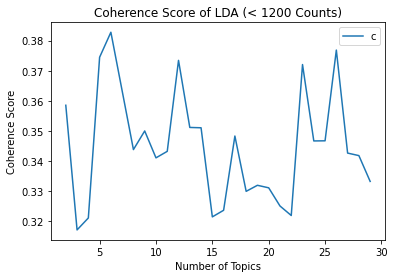

In [230]:
coherence_score(1200, passes=10)

In [235]:
#Corpus별 표제어(lemmatization) 추출
tokenizer = RegexpTokenizer('\w+')
p_stemmer = PorterStemmer()
texts = []
for item in cps_data:
    #corpus 속 숫자 제거
    temp = re.sub('[0-9]+','',item)
    tokens = tokenizer.tokenize(temp)
    #1글자로 이루어진 단어 제거
    tokens_overone = [word for word in tokens if (len(word) > 1)]
    #stopword 제거
    stopped_tokens = [i for i in tokens_overone if not i in stword]    
    # ing형 제거
    noning_tokens = [word for word in stopped_tokens if (re.findall('ing$', word) == [])]
    # ly형 제거
    nonly_tokens = [word for word in noning_tokens if (re.findall('ly$', word) == [])]
    #각 단어 표제화
    lemmatized_words = [wnl.lemmatize(i) for i in nonly_tokens]
    texts.append(lemmatized_words)

limit = 1200
num_tps = 5
frequency = {}
for corpus in texts:
    for word in corpus:
        if word in frequency.keys():
            frequency[word] +=1
        else:
            frequency[word] = 1
texts_filtered = [ [token for token in text if (1 < frequency[token]<limit)] for text in texts ]

#표제화된 단어들을 이용하여 document-term 테이블 생성
dictionary = Dictionary(texts_filtered)
docfreq = dictionary.dfs
doc_term_matrix = [dictionary.doc2bow(i) for i in texts]

ldaModel = models.ldamodel.LdaModel(corpus=doc_term_matrix, num_topics = num_tps, id2word = dictionary, 
                                    passes=10, alpha = 'symmetric', iterations = 10)
ldaTopics = ldaModel.print_topics(num_topics = num_tps, num_words = 15)
keywords_usa = []
for i in range(len(ldaTopics)):
    string = ''
    for item in ldaTopics[i][1].split('+'):
        string += (item.split('*')[1].replace(r'"','') + '')
    keywords_usa.append(['Topic ' + str(ldaTopics[i][0])] + [string.replace(' ',', ')])
topic_ratio_usa = []
for i in range(len(doc_term_matrix)):
    topic_ratio_usa.append(ldaModel[doc_term_matrix[i]])

In [234]:
stword.extend(['bp'])

In [236]:
keywords_usa

[['Topic 0',
  'ai, model, based, program, system, education, design, machine, project, approach, university, method, result, college, research'],
 ['Topic 1',
  'course, science, class, approach, result, based, instructor, tool, research, content, design, classroom, deeper, feedback, teacher'],
 ['Topic 2',
  'based, analysis, machine, system, result, concept, problem, model, method, level, research, game, approach, school, application'],
 ['Topic 3',
  'teacher, school, education, practice, research, experience, based, development, community, classroom, program, social, need, deep, knowledge'],
 ['Topic 4',
  'model, teacher, machine, research, education, network, time, science, method, social, classroom, design, process, based, question']]

In [237]:
for topic in keywords_usa:
    for line in topic:
        for item in line.split(','):
            print(item.replace(' ',''))

Topic0
ai
model
based
program
system
education
design
machine
project
approach
university
method
result
college
research
Topic1
course
science
class
approach
result
based
instructor
tool
research
content
design
classroom
deeper
feedback
teacher
Topic2
based
analysis
machine
system
result
concept
problem
model
method
level
research
game
approach
school
application
Topic3
teacher
school
education
practice
research
experience
based
development
community
classroom
program
social
need
deep
knowledge
Topic4
model
teacher
machine
research
education
network
time
science
method
social
classroom
design
process
based
question


## China Topic Modeling

In [238]:
i = 0
cps_name, cps_data = [], []
for item in df_filtered[df_filtered['Country'] == 'China']['Abstract']:
    globals()['cps{}'.format(i)] = item.lower()
    cps_name.append('cps{}'.format(i))
    cps_data.append(globals()['cps{}'.format(i)])
    i += 1

In [239]:
#Corpus별 표제어(lemmatization) 추출
tokenizer = RegexpTokenizer('\w+')
p_stemmer = PorterStemmer()
texts = []
for item in cps_data:
    #corpus 속 숫자 제거
    temp = re.sub('[0-9]+','',item)
    tokens = tokenizer.tokenize(temp)
    #1글자로 이루어진 단어 제거
    tokens_overone = [word for word in tokens if (len(word) > 1)]
    #stopword 제거
    stopped_tokens = [i for i in tokens_overone if not i in stword]    
    # ing형 제거
    noning_tokens = [word for word in stopped_tokens if (re.findall('ing$', word) == [])]
    # ly형 제거
    nonly_tokens = [word for word in noning_tokens if (re.findall('ly$', word) == [])]
    #각 단어 표제화
    lemmatized_words = [wnl.lemmatize(i) for i in nonly_tokens]
    texts.append(lemmatized_words)

frequency = {}
for corpus in texts:
    for word in corpus:
        if word in frequency.keys():
            frequency[word] +=1
        else:
            frequency[word] = 1
texts_filtered = [ [token for token in text if (1 < frequency[token]) ] for text in texts ]

#표제화된 단어들을 이용하여 document-term 테이블 생성
dictionary = Dictionary(texts_filtered)
docfreq = dictionary.dfs
doc_term_matrix = [dictionary.doc2bow(i) for i in texts]

In [240]:
stword.extend(['among', 'based'])

4547


Text(0, 0.5, 'Frequency')

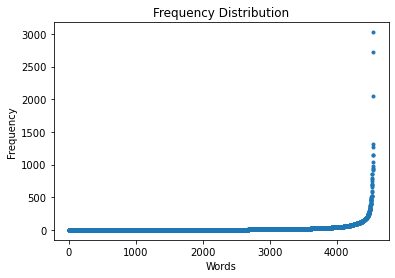

In [242]:
#Cheking the freqeuency distribution with all words.
term_dic = {}
for texts in doc_term_matrix:
    for item in texts:
        if item[0] in term_dic.keys():
            term_dic[item[0]] += item[1]
        else:
            term_dic[item[0]] = 1
term_dic_sorted = sorted(term_dic.items(), key = operator.itemgetter(1))
x , y = [] ,[]
for i in range(len(term_dic_sorted)):
    y.append(term_dic_sorted[i][1])
    x.append(i)
print(len(term_dic_sorted))
plt.plot(x,y, '.')
plt.title('Frequency Distribution')
plt.xlabel('Words')
plt.ylabel('Frequency')

In [243]:
for item in sorted(term_dic.items(), key = operator.itemgetter(1), reverse = True)[0:30]:
    print(dictionary[item[0]], item[1])

student 3024
data 2715
education 2049
model 1318
college 1270
method 1150
based 1144
system 1047
university 980
technology 952
network 928
information 917
teacher 856
development 850
result 795
study 779
analysis 751
course 702
english 692
research 681
evaluation 654
algorithm 593
quality 583
classroom 526
deep 517
application 517
problem 515
process 497
improve 495
performance 477


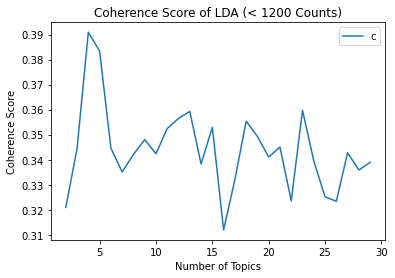

In [249]:
coherence_score(1200, passes = 10)

In [250]:
#Corpus별 표제어(lemmatization) 추출
tokenizer = RegexpTokenizer('\w+')
p_stemmer = PorterStemmer()
texts = []
for item in cps_data:
    #corpus 속 숫자 제거
    temp = re.sub('[0-9]+','',item)
    tokens = tokenizer.tokenize(temp)
    #1글자로 이루어진 단어 제거
    tokens_overone = [word for word in tokens if (len(word) > 1)]
    #stopword 제거
    stopped_tokens = [i for i in tokens_overone if not i in stword]    
    # ing형 제거
    noning_tokens = [word for word in stopped_tokens if (re.findall('ing$', word) == [])]
    # ly형 제거
    nonly_tokens = [word for word in noning_tokens if (re.findall('ly$', word) == [])]
    #각 단어 표제화
    lemmatized_words = [wnl.lemmatize(i) for i in nonly_tokens]
    texts.append(lemmatized_words)

limit = 1200
num_tps = 5
frequency = {}
for corpus in texts:
    for word in corpus:
        if word in frequency.keys():
            frequency[word] +=1
        else:
            frequency[word] = 1
texts_filtered = [ [token for token in text if (1 < frequency[token]<limit)] for text in texts ]

#표제화된 단어들을 이용하여 document-term 테이블 생성
dictionary = Dictionary(texts_filtered)
docfreq = dictionary.dfs
doc_term_matrix = [dictionary.doc2bow(i) for i in texts]

ldaModel = models.ldamodel.LdaModel(corpus=doc_term_matrix, num_topics = num_tps, id2word = dictionary, 
                                    passes=10, alpha = 'symmetric', iterations = 10)
ldaTopics = ldaModel.print_topics(num_topics = num_tps, num_words = 15)
keywords_china = []
for i in range(len(ldaTopics)):
    string = ''
    for item in ldaTopics[i][1].split('+'):
        string += (item.split('*')[1].replace(r'"','') + '')
    keywords_china.append(['Topic ' + str(ldaTopics[i][0])] + [string.replace(' ',', ')])
topic_ratio_china = []
for i in range(len(doc_term_matrix)):
    topic_ratio_china.append(ldaModel[doc_term_matrix[i]])

In [136]:
keywords_china

[['Topic 0',
  'online, course, system, study, ai, group, mooc, educational, result, resource, analysis, method, open, application, quality'],
 ['Topic 1',
  'model, evaluation, network, algorithm, method, neural, result, quality, system, proposed, analysis, show, performance, college, prediction'],
 ['Topic 2',
  'english, college, ideological, political, study, teacher, language, ability, deep, analysis, method, school, knowledge, research, factor'],
 ['Topic 3',
  'technology, information, system, college, service, course, library, method, development, design, university, problem, knowledge, resource, application'],
 ['Topic 4',
  'model, network, method, teacher, feature, result, proposed, performance, behavior, recognition, neural, accuracy, deep, prediction, study'],
 ['Topic 5',
  'algorithm, method, artificial, design, music, model, intelligence, system, performance, process, optimization, experiment, art, experimental, robot'],
 ['Topic 6',
  'technology, classroom, informatio

In [251]:
for topic in keywords_china:
    for line in topic:
        for item in line.split(','):
            print(item.replace(' ',''))

Topic0
english
evaluation
network
method
teacher
quality
neural
result
deep
language
knowledge
ability
school
system
study
Topic1
university
technology
development
information
system
management
analysis
course
era
method
research
resource
improve
application
quality
Topic2
algorithm
study
network
ideological
method
result
political
factor
proposed
performance
assessment
approach
course
university
neural
Topic3
method
teacher
study
result
feature
online
research
performance
network
experiment
analysis
machine
recognition
proposed
behavior
Topic4
classroom
system
technology
application
time
information
teacher
school
result
algorithm
method
analysis
study
english
class


In [252]:
keywords_china_byword = []
for topic in keywords_china:
    for words in topic:
        for word in words.split(','):
            keywords_china_byword.append(word.replace(' ',''))

In [253]:
keywords_usa_byword = []
for topic in keywords_usa:
    for words in topic:
        for word in words.split(','):
            keywords_usa_byword.append(word.replace(' ',''))

In [254]:
keywords_byword = []
for topic in keywords:
    for words in topic:
        for word in words.split(','):
            keywords_byword.append(word.replace(' ',''))

In [255]:
for word in keywords_usa_byword:
    if word not in keywords_byword:
        print(word)

ai
program
education
project
class
instructor
content
classroom
feedback
concept
game
education
community
classroom
program
need
education
time
classroom
question


In [256]:
for word in keywords_china_byword:
    if word not in keywords_byword:
        print(word)

evaluation
quality
ability
study
era
resource
improve
quality
study
ideological
political
factor
study
experiment
recognition
behavior
classroom
time
study
class


## Backward Citation Setup

In [138]:
df_back = pd.read_excel(r'C:\Users\Yunseok Choi\Google 드라이브\기술경영대학원\STEPI\AI_Education_backwardcitation.xlsx')
df_back.dropna(subset = ['Abstract','Publication Year'], inplace = True, axis = 0)

In [139]:
df_back.reset_index(inplace = True)

In [145]:
df_back.shape

(137728, 71)

In [160]:
wos_usa = []
for item in usa_index:
    wos_usa.append(df_filtered.iloc[item]['UT (Unique WOS ID)'])

In [141]:
wos_china = []
for item in china_index:
    wos_china.append(df_filtered.iloc[item]['UT (Unique WOS ID)'])

In [161]:
cps_data_china, cps_data_usa = [], []
back_index_china , back_index_usa = [], []
for i in range(df_back.shape[0]):
    if df_back['CIted By'][i] in wos_china:
        cps_data_china.append(df_back['Abstract'][i].lower())
        back_index_china.append(i)
    elif df_back['CIted By'][i] in wos_usa:
        cps_data_usa.append(df_back['Abstract'][i].lower())
        back_index_usa.append(i)

In [164]:
len(cps_data_usa)

19258

In [165]:
len(cps_data_china)

10240

## Backward Citation

In [146]:
cps_data_back = []
for item in df_back['Abstract']:
    cps_data_back.append(item.lower())

In [168]:
#Corpus별 표제어(lemmatization) 추출
tokenizer = RegexpTokenizer('\w+')
p_stemmer = PorterStemmer()
texts = []
for item in cps_data_back:
    #corpus 속 숫자 제거
    temp = re.sub('[0-9]+','',item)
    tokens = tokenizer.tokenize(temp)
    #1글자로 이루어진 단어 제거
    tokens_overone = [word for word in tokens if len(word) > 1]
    #stopword 제거
    stopped_tokens = [i for i in tokens_overone if not i in stword]    
    # ing형 제거
    noning_tokens = [word for word in stopped_tokens if (re.findall('ing$', word) == [])]
    # ly형 제거
    nonly_tokens = [word for word in noning_tokens if (re.findall('ly$', word) == [])]
    #각 단어 표제화
    lemmatized_words = [wnl.lemmatize(i) for i in nonly_tokens]
    texts.append(lemmatized_words)

frequency = {}
for corpus in texts:
    for word in corpus:
        if word in frequency.keys():
            frequency[word] +=1
        else:
            frequency[word] = 1
texts_filtered = [ [token for token in text if (1 < frequency[token]) ] for text in texts ]

#표제화된 단어들을 이용하여 document-term 테이블 생성
dictionary = Dictionary(texts_filtered)
docfreq = dictionary.dfs
doc_term_matrix = [dictionary.doc2bow(i) for i in texts]

60308


Text(0, 0.5, 'Frequency')

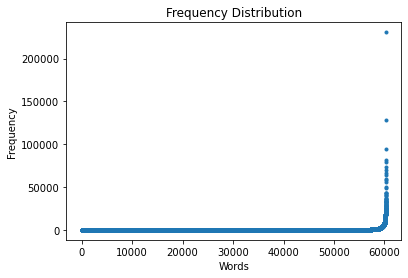

In [169]:
#Cheking the freqeuency distribution with all words.
term_dic = {}
for texts in doc_term_matrix:
    for item in texts:
        if item[0] in term_dic.keys():
            term_dic[item[0]] += item[1]
        else:
            term_dic[item[0]] = 1
term_dic_sorted = sorted(term_dic.items(), key = operator.itemgetter(1))
x , y = [] ,[]
for i in range(len(term_dic_sorted)):
    y.append(term_dic_sorted[i][1])
    x.append(i)
print(len(term_dic_sorted))
plt.plot(x,y, '.')
plt.title('Frequency Distribution')
plt.xlabel('Words')
plt.ylabel('Frequency')

In [170]:
for item in sorted(term_dic.items(), key = operator.itemgetter(1), reverse = True)[0:30]:
    print(dictionary[item[0]], item[1])

student 230796
study 128274
data 94158
model 81309
result 79577
research 73663
approach 70105
method 66852
education 64448
system 58940
teacher 57872
analysis 56528
performance 49597
school 49333
group 43668
knowledge 43411
process 42616
problem 41084
course 40354
level 39610
different 37022
self 36085
development 36067
time 36041
effect 34959
factor 33916
information 33432
network 33395
practice 33002
design 32776


In [152]:
coherence_score(70000, passes = 15, cps_data = cps_data_back)

KeyboardInterrupt: 

In [167]:
#Corpus별 표제어(lemmatization) 추출
tokenizer = RegexpTokenizer('\w+')
p_stemmer = PorterStemmer()
texts = []
for item in cps_data_back:
    #corpus 속 숫자 제거
    temp = re.sub('[0-9]+','',item)
    tokens = tokenizer.tokenize(temp)
    #1글자로 이루어진 단어 제거
    tokens_overone = [word for word in tokens if len(word) > 1]
    #stopword 제거
    stopped_tokens = [i for i in tokens_overone if not i in stword]    
    # ing형 제거
    noning_tokens = [word for word in stopped_tokens if (re.findall('ing$', word) == [])]
    # ly형 제거
    nonly_tokens = [word for word in noning_tokens if (re.findall('ly$', word) == [])]
    #각 단어 표제화
    lemmatized_words = [wnl.lemmatize(i) for i in nonly_tokens]
    #filtered_words = [word for word in lemmatized_words if not word in filter_words]
    texts.append(lemmatized_words)


limit = 70000
num_tps = 8
frequency = {}
for corpus in texts:
    for word in corpus:
        if word in frequency.keys():
            frequency[word] +=1
        else:
            frequency[word] = 1
texts_filtered = [ [token for token in text if (1 < frequency[token]<limit)] for text in texts ]

#표제화된 단어들을 이용하여 document-term 테이블 생성
dictionary = Dictionary(texts_filtered)
docfreq = dictionary.dfs
doc_term_matrix = [dictionary.doc2bow(i) for i in texts]

ldaModel = models.ldamodel.LdaModel(corpus=doc_term_matrix, num_topics = num_tps, id2word = dictionary, 
                                    passes=15, alpha = 'symmetric', iterations = 10)
ldaTopics = ldaModel.print_topics(num_topics = num_tps, num_words = 15)
keywords = []
for i in range(len(ldaTopics)):
    string = ''
    for item in ldaTopics[i][1].split('+'):
        string += (item.split('*')[1].replace(r'"','') + '')
    keywords.append(['Topic ' + str(ldaTopics[i][0])] + [string.replace(' ',', ')])
topic_ratio = []
for i in range(len(doc_term_matrix)):
    topic_ratio.append(ldaModel[doc_term_matrix[i]])

In [171]:
keywords

[['Topic 0',
  'course, group, skill, medical, education, program, method, class, experience, university, online, clinical, assessment, feedback, undergraduate'],
 ['Topic 1',
  'self, school, academic, effect, performance, achievement, relationship, motivation, child, level, positive, factor, behavior, social, grade'],
 ['Topic 2',
  'education, university, school, social, development, management, service, institution, policy, college, country, educational, business, public, impact'],
 ['Topic 3',
  'health, patient, risk, child, age, group, ai, year, treatment, conclusion, disease, associated, physical, rate, mental'],
 ['Topic 4',
  'network, method, algorithm, neural, performance, feature, proposed, machine, problem, accuracy, classification, prediction, image, time, show'],
 ['Topic 5',
  'system, technology, information, application, tool, computer, user, machine, environment, ai, learner, educational, online, design, technique'],
 ['Topic 6',
  'deep, test, factor, analysis, eng

In [ ]:
topic_ratio_all = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0}
for index in range(0,df_filtered.shape[0],1):
    for item in topic_ratio[index]:
        topic_ratio_all[item[0]] += item[1]
for index in topic_ratio_all.keys():
    topic_ratio_all[index] = topic_ratio_all[index]/df_filtered.shape[0]
topic_ratio_all

In [172]:
topic_ratio_usa = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0}
for index in back_index_usa:
    for item in topic_ratio[index]:
        topic_ratio_usa[item[0]] += item[1]
for index in topic_ratio_usa.keys():
    topic_ratio_usa[index] = topic_ratio_usa[index]/len(back_index_usa)
topic_ratio_usa

{0: 0.1144559320512343,
 1: 0.117031102211772,
 2: 0.10715677145196718,
 3: 0.12197268693745121,
 4: 0.16147309833121412,
 5: 0.11969609139656408,
 6: 0.04191635279164804,
 7: 0.20855478953372045,
 8: 0.0,
 9: 0.0,
 10: 0.0}

In [173]:
topic_ratio_china = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0}
for index in back_index_china:
    for item in topic_ratio[index]:
        topic_ratio_china[item[0]] += item[1]
for index in topic_ratio_china.keys():
    topic_ratio_china[index] = topic_ratio_china[index]/len(back_index_china)
topic_ratio_china

{0: 0.06530947707988162,
 1: 0.09082949665462366,
 2: 0.08435224318527616,
 3: 0.06670096741772795,
 4: 0.36991391040864985,
 5: 0.15951897885961444,
 6: 0.04881490166117146,
 7: 0.10637417611069395,
 8: 0.0,
 9: 0.0,
 10: 0.0}

## USA Backward Citation

In [175]:
#Corpus별 표제어(lemmatization) 추출
tokenizer = RegexpTokenizer('\w+')
p_stemmer = PorterStemmer()
texts = []
for item in cps_data_usa:
    #corpus 속 숫자 제거
    temp = re.sub('[0-9]+','',item)
    tokens = tokenizer.tokenize(temp)
    #1글자로 이루어진 단어 제거
    tokens_overone = [word for word in tokens if len(word) > 1]
    #stopword 제거
    stopped_tokens = [i for i in tokens_overone if not i in stword]    
    # ing형 제거
    noning_tokens = [word for word in stopped_tokens if (re.findall('ing$', word) == [])]
    # ly형 제거
    nonly_tokens = [word for word in noning_tokens if (re.findall('ly$', word) == [])]
    #각 단어 표제화
    lemmatized_words = [wnl.lemmatize(i) for i in nonly_tokens]
    texts.append(lemmatized_words)

frequency = {}
for corpus in texts:
    for word in corpus:
        if word in frequency.keys():
            frequency[word] +=1
        else:
            frequency[word] = 1
texts_filtered = [ [token for token in text if (1 < frequency[token]) ] for text in texts ]

#표제화된 단어들을 이용하여 document-term 테이블 생성
dictionary = Dictionary(texts_filtered)
docfreq = dictionary.dfs
doc_term_matrix = [dictionary.doc2bow(i) for i in texts]

22771


Text(0, 0.5, 'Frequency')

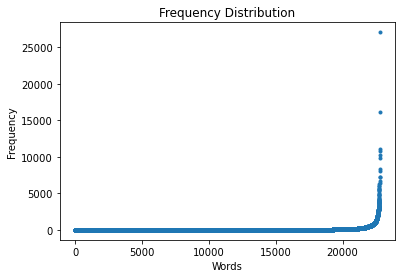

In [176]:
#Cheking the freqeuency distribution with all words.
term_dic = {}
for texts in doc_term_matrix:
    for item in texts:
        if item[0] in term_dic.keys():
            term_dic[item[0]] += item[1]
        else:
            term_dic[item[0]] = 1
term_dic_sorted = sorted(term_dic.items(), key = operator.itemgetter(1))
x , y = [] ,[]
for i in range(len(term_dic_sorted)):
    y.append(term_dic_sorted[i][1])
    x.append(i)
print(len(term_dic_sorted))
plt.plot(x,y, '.')
plt.title('Frequency Distribution')
plt.xlabel('Words')
plt.ylabel('Frequency')

In [177]:
for item in sorted(term_dic.items(), key = operator.itemgetter(1), reverse = True)[0:30]:
    print(dictionary[item[0]], item[1])

student 27064
study 16095
data 11081
model 10858
research 10289
result 9841
teacher 8287
method 8028
school 7304
analysis 7286
education 6700
approach 6387
system 6315
effect 6072
group 6040
practice 5731
problem 5671
knowledge 5587
science 5515
performance 5485
level 5286
time 5071
development 4935
process 4827
course 4795
design 4791
program 4459
self 4437
health 4179
social 4168


In [178]:
#Corpus별 표제어(lemmatization) 추출
tokenizer = RegexpTokenizer('\w+')
p_stemmer = PorterStemmer()
texts = []
for item in cps_data_usa:
    #corpus 속 숫자 제거
    temp = re.sub('[0-9]+','',item)
    tokens = tokenizer.tokenize(temp)
    #1글자로 이루어진 단어 제거
    tokens_overone = [word for word in tokens if len(word) > 1]
    #stopword 제거
    stopped_tokens = [i for i in tokens_overone if not i in stword]    
    # ing형 제거
    noning_tokens = [word for word in stopped_tokens if (re.findall('ing$', word) == [])]
    # ly형 제거
    nonly_tokens = [word for word in noning_tokens if (re.findall('ly$', word) == [])]
    #각 단어 표제화
    lemmatized_words = [wnl.lemmatize(i) for i in nonly_tokens]
    #filtered_words = [word for word in lemmatized_words if not word in filter_words]
    texts.append(lemmatized_words)


limit = 10000
num_tps = 8
frequency = {}
for corpus in texts:
    for word in corpus:
        if word in frequency.keys():
            frequency[word] +=1
        else:
            frequency[word] = 1
texts_filtered = [ [token for token in text if (1 < frequency[token]<limit)] for text in texts ]

#표제화된 단어들을 이용하여 document-term 테이블 생성
dictionary = Dictionary(texts_filtered)
docfreq = dictionary.dfs
doc_term_matrix = [dictionary.doc2bow(i) for i in texts]

ldaModel = models.ldamodel.LdaModel(corpus=doc_term_matrix, num_topics = num_tps, id2word = dictionary, 
                                    passes=15, alpha = 'symmetric', iterations = 10)
ldaTopics = ldaModel.print_topics(num_topics = num_tps, num_words = 15)
keywords = []
for i in range(len(ldaTopics)):
    string = ''
    for item in ldaTopics[i][1].split('+'):
        string += (item.split('*')[1].replace(r'"','') + '')
    keywords.append(['Topic ' + str(ldaTopics[i][0])] + [string.replace(' ',', ')])
topic_ratio = []
for i in range(len(doc_term_matrix)):
    topic_ratio.append(ldaModel[doc_term_matrix[i]])

In [179]:
keywords

[['Topic 0',
  'method, system, network, algorithm, approach, image, feature, information, machine, result, set, performance, time, problem, application'],
 ['Topic 1',
  'brain, cell, response, activity, region, energy, neuron, protein, result, effect, functional, area, human, gene, function'],
 ['Topic 2',
  'health, american, alcohol, community, college, youth, ai, school, care, risk, program, service, population, indian, intervention'],
 ['Topic 3',
  'child, patient, age, effect, risk, school, result, year, group, treatment, outcome, intervention, score, time, rate'],
 ['Topic 4',
  'teacher, education, practice, science, development, school, article, knowledge, design, technology, educational, classroom, approach, curriculum, experience'],
 ['Topic 5',
  'medical, self, clinical, result, academic, factor, relationship, patient, measure, performance, analysis, outcome, care, method, effect'],
 ['Topic 6',
  'theory, system, cognitive, human, social, process, interaction, behavior,

## China Backward Citation

In [181]:
#Corpus별 표제어(lemmatization) 추출
tokenizer = RegexpTokenizer('\w+')
p_stemmer = PorterStemmer()
texts = []
for item in cps_data_china:
    #corpus 속 숫자 제거
    temp = re.sub('[0-9]+','',item)
    tokens = tokenizer.tokenize(temp)
    #1글자로 이루어진 단어 제거
    tokens_overone = [word for word in tokens if len(word) > 1]
    #stopword 제거
    stopped_tokens = [i for i in tokens_overone if not i in stword]    
    # ing형 제거
    noning_tokens = [word for word in stopped_tokens if (re.findall('ing$', word) == [])]
    # ly형 제거
    nonly_tokens = [word for word in noning_tokens if (re.findall('ly$', word) == [])]
    #각 단어 표제화
    lemmatized_words = [wnl.lemmatize(i) for i in nonly_tokens]
    texts.append(lemmatized_words)

frequency = {}
for corpus in texts:
    for word in corpus:
        if word in frequency.keys():
            frequency[word] +=1
        else:
            frequency[word] = 1
texts_filtered = [ [token for token in text if (1 < frequency[token]) ] for text in texts ]

#표제화된 단어들을 이용하여 document-term 테이블 생성
dictionary = Dictionary(texts_filtered)
docfreq = dictionary.dfs
doc_term_matrix = [dictionary.doc2bow(i) for i in texts]

16869


Text(0, 0.5, 'Frequency')

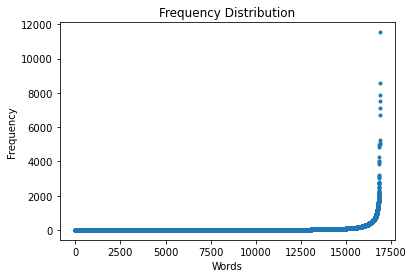

In [182]:
#Cheking the freqeuency distribution with all words.
term_dic = {}
for texts in doc_term_matrix:
    for item in texts:
        if item[0] in term_dic.keys():
            term_dic[item[0]] += item[1]
        else:
            term_dic[item[0]] = 1
term_dic_sorted = sorted(term_dic.items(), key = operator.itemgetter(1))
x , y = [] ,[]
for i in range(len(term_dic_sorted)):
    y.append(term_dic_sorted[i][1])
    x.append(i)
print(len(term_dic_sorted))
plt.plot(x,y, '.')
plt.title('Frequency Distribution')
plt.xlabel('Words')
plt.ylabel('Frequency')

In [183]:
for item in sorted(term_dic.items(), key = operator.itemgetter(1), reverse = True)[0:30]:
    print(dictionary[item[0]], item[1])

student 11538
data 8591
model 7883
study 7526
method 7124
result 6735
system 5222
approach 5102
algorithm 5038
network 4980
performance 4849
proposed 4274
problem 4021
analysis 3955
research 3861
feature 3232
different 3120
time 3094
education 3016
course 2812
image 2764
teacher 2763
information 2751
process 2727
show 2664
group 2523
level 2522
knowledge 2478
elsevier 2469
right 2341


In [184]:
#Corpus별 표제어(lemmatization) 추출
tokenizer = RegexpTokenizer('\w+')
p_stemmer = PorterStemmer()
texts = []
for item in cps_data_china:
    #corpus 속 숫자 제거
    temp = re.sub('[0-9]+','',item)
    tokens = tokenizer.tokenize(temp)
    #1글자로 이루어진 단어 제거
    tokens_overone = [word for word in tokens if len(word) > 1]
    #stopword 제거
    stopped_tokens = [i for i in tokens_overone if not i in stword]    
    # ing형 제거
    noning_tokens = [word for word in stopped_tokens if (re.findall('ing$', word) == [])]
    # ly형 제거
    nonly_tokens = [word for word in noning_tokens if (re.findall('ly$', word) == [])]
    #각 단어 표제화
    lemmatized_words = [wnl.lemmatize(i) for i in nonly_tokens]
    #filtered_words = [word for word in lemmatized_words if not word in filter_words]
    texts.append(lemmatized_words)


limit = 4100
num_tps = 8
frequency = {}
for corpus in texts:
    for word in corpus:
        if word in frequency.keys():
            frequency[word] +=1
        else:
            frequency[word] = 1
texts_filtered = [ [token for token in text if (1 < frequency[token]<limit)] for text in texts ]

#표제화된 단어들을 이용하여 document-term 테이블 생성
dictionary = Dictionary(texts_filtered)
docfreq = dictionary.dfs
doc_term_matrix = [dictionary.doc2bow(i) for i in texts]

ldaModel = models.ldamodel.LdaModel(corpus=doc_term_matrix, num_topics = num_tps, id2word = dictionary, 
                                    passes=15, alpha = 'symmetric', iterations = 10)
ldaTopics = ldaModel.print_topics(num_topics = num_tps, num_words = 15)
keywords = []
for i in range(len(ldaTopics)):
    string = ''
    for item in ldaTopics[i][1].split('+'):
        string += (item.split('*')[1].replace(r'"','') + '')
    keywords.append(['Topic ' + str(ldaTopics[i][0])] + [string.replace(' ',', ')])
topic_ratio = []
for i in range(len(doc_term_matrix)):
    topic_ratio.append(ldaModel[doc_term_matrix[i]])

In [185]:
keywords

[['Topic 0',
  'problem, optimization, function, energy, parameter, simulation, right, elsevier, solution, reserved, process, show, control, search, optimal'],
 ['Topic 1',
  'research, education, teacher, technology, development, assessment, practice, educational, knowledge, classroom, article, review, language, english, concept'],
 ['Topic 2',
  'course, user, online, learner, interaction, information, environment, computer, activity, behavior, problem, different, recommendation, tool, knowledge'],
 ['Topic 3',
  'image, feature, recognition, deep, task, domain, state, neural, object, art, propose, detection, classification, accuracy, representation'],
 ['Topic 4',
  'control, mobile, brain, cloud, functional, device, gene, spectrum, sensor, activity, structure, human, dynamic, cell, effect'],
 ['Topic 5',
  'self, academic, social, factor, effect, relationship, analysis, motivation, achievement, university, level, positive, school, research, group'],
 ['Topic 6',
  'machine, time, p